In [73]:
import numpy as np
import xgboost as xgb
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline

## Construct a simulated data set for testing monotonic constraintsx

In [74]:
N, K = (1000, 2)
pi = 3.14159

In [75]:
X = np.random.random(size=(N, K))
y = (5*X[:, 0] + np.sin(5*2*pi*X[:, 0])
     - 5*X[:, 1] - np.cos(5*2*pi*X[:, 1])
     #+ 0.01*np.sin(5*2*pi*X[:, 0])*np.cos(5*2*pi*X[:, 1])
     + np.random.normal(loc=0.0, scale=0.01, size=N))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

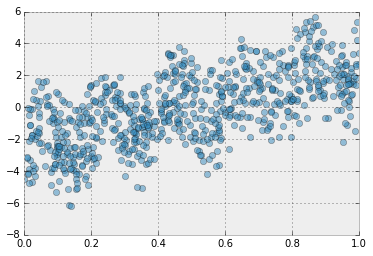

In [77]:
plt.plot(X_train[:, 0], y_train, 'o', alpha = 0.5)

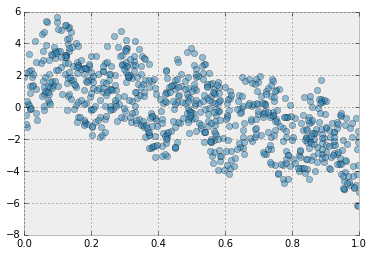

In [78]:
plt.plot(X_train[:, 1], y_train, 'o', alpha = 0.5)

## Fit a xgboost model - Unconstrained

In [85]:
params = {
    'max_depth': 2,
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'rmse',
    'seed': 154
}

Train a xgboost model on only the first feature, the ground truth is a sin wave superimposed on an **increasing** trend.

In [87]:
dtrain = xgb.DMatrix(X_train[:, [0]], label = y_train)
dvalid = xgb.DMatrix(X_test[:, [0]], label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.19811	eval-rmse:2.24719
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.10836	eval-rmse:2.15505
[2]	train-rmse:2.03259	eval-rmse:2.07813
[3]	train-rmse:1.96825	eval-rmse:2.01149
[4]	train-rmse:1.91418	eval-rmse:1.95434
[5]	train-rmse:1.8687	eval-rmse:1.90671
[6]	train-rmse:1.83059	eval-rmse:1.86533
[7]	train-rmse:1.79879	eval-rmse:1.83131
[8]	train-rmse:1.77231	eval-rmse:1.80329
[9]	train-rmse:1.75028	eval-rmse:1.78049
[10]	train-rmse:1.73205	eval-rmse:1.76085
[11]	train-rmse:1.71686	eval-rmse:1.74409
[12]	train-rmse:1.70391	eval-rmse:1.73312
[13]	train-rmse:1.69221	eval-rmse:1.72269
[14]	train-rmse:1.68246	eval-rmse:1.71518
[15]	train-rmse:1.67283	eval-rmse:1.70656
[16]	train-rmse:1.66454	eval-rmse:1.69993
[17]	train-rmse:1.65679	eval-rmse:1.69473
[18]	train-rmse:1.65016	eval-rmse:1.68914
[19]	train-rmse:1.64234	eval-rmse:1.68389
[20]	train-rmse:1.63715	eval

In [66]:
def plot_one_feature_prediction(bst, X, y, title):
    """For one-feature model, plot data and prediction."""
    
    x_scan = np.linspace(0, 1, 100)
    x_plot = xgb.DMatrix(x_scan.reshape((len(x_scan),1)))
    y_plot = bst.predict(x_plot, ntree_limit = bst.best_ntree_limit)

    plt.plot(x_scan, y_plot, color = 'black')
    plt.plot(X, y, 'o', alpha = 0.25)

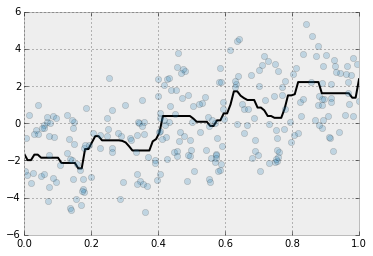

In [69]:
plot_one_feature_prediction(model_no_constraints, X_test[:, 0], y_test, "")

Add a monotonic constraint - constrain feature to be fit monotonically.

In [88]:
params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.19811	eval-rmse:2.24719
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.10836	eval-rmse:2.15505
[2]	train-rmse:2.03259	eval-rmse:2.07813
[3]	train-rmse:1.96825	eval-rmse:2.01149
[4]	train-rmse:1.91418	eval-rmse:1.95434
[5]	train-rmse:1.8687	eval-rmse:1.90671
[6]	train-rmse:1.83059	eval-rmse:1.86533
[7]	train-rmse:1.79879	eval-rmse:1.83131
[8]	train-rmse:1.77231	eval-rmse:1.80329
[9]	train-rmse:1.75028	eval-rmse:1.78049
[10]	train-rmse:1.73205	eval-rmse:1.76085
[11]	train-rmse:1.71686	eval-rmse:1.74409
[12]	train-rmse:1.70415	eval-rmse:1.72978
[13]	train-rmse:1.69322	eval-rmse:1.71759
[14]	train-rmse:1.68432	eval-rmse:1.70748
[15]	train-rmse:1.67663	eval-rmse:1.69952
[16]	train-rmse:1.67043	eval-rmse:1.6923
[17]	train-rmse:1.66503	eval-rmse:1.68675
[18]	train-rmse:1.66064	eval-rmse:1.6817
[19]	train-rmse:1.65681	eval-rmse:1.67727
[20]	train-rmse:1.6537	eval-rm

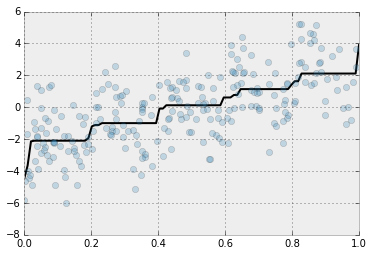

In [89]:
plot_one_feature_prediction(model_with_constraints, X_test[:, 0], y_test, "")

Train a xgboost model on only the first feature, the ground truth is a sin wave superimposed on an **decreasing** trend.

In [91]:
dtrain = xgb.DMatrix(X_train[:, [1]], label = y_train)
dvalid = xgb.DMatrix(X_test[:, [1]], label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.19171	eval-rmse:2.24214
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.0971	eval-rmse:2.14767
[2]	train-rmse:2.01705	eval-rmse:2.06407
[3]	train-rmse:1.94621	eval-rmse:1.99537
[4]	train-rmse:1.8868	eval-rmse:1.93799
[5]	train-rmse:1.83612	eval-rmse:1.88494
[6]	train-rmse:1.79356	eval-rmse:1.83969
[7]	train-rmse:1.75729	eval-rmse:1.80515
[8]	train-rmse:1.72693	eval-rmse:1.77229
[9]	train-rmse:1.70168	eval-rmse:1.74432
[10]	train-rmse:1.67921	eval-rmse:1.72616
[11]	train-rmse:1.66056	eval-rmse:1.71063
[12]	train-rmse:1.64521	eval-rmse:1.70018
[13]	train-rmse:1.63156	eval-rmse:1.6852
[14]	train-rmse:1.62022	eval-rmse:1.6739
[15]	train-rmse:1.61088	eval-rmse:1.66386
[16]	train-rmse:1.60231	eval-rmse:1.65783
[17]	train-rmse:1.59526	eval-rmse:1.65417
[18]	train-rmse:1.58931	eval-rmse:1.6476
[19]	train-rmse:1.58405	eval-rmse:1.64123
[20]	train-rmse:1.579	eval-rmse:

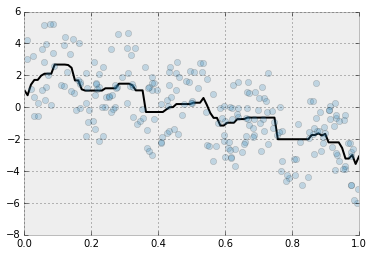

In [92]:
plot_one_feature_prediction(model_no_constraints, X_test[:, 1], y_test, "")

In [93]:
params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(-1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.28534	eval-rmse:2.33215
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.27143	eval-rmse:2.31468
[2]	train-rmse:2.26056	eval-rmse:2.30055
[3]	train-rmse:2.25214	eval-rmse:2.28914
[4]	train-rmse:2.24568	eval-rmse:2.27994
[5]	train-rmse:2.24078	eval-rmse:2.27255
[6]	train-rmse:2.23711	eval-rmse:2.26661
[7]	train-rmse:2.23441	eval-rmse:2.26186
[8]	train-rmse:2.23248	eval-rmse:2.25807
[9]	train-rmse:2.23114	eval-rmse:2.25505
[10]	train-rmse:2.23026	eval-rmse:2.25265
[11]	train-rmse:2.22974	eval-rmse:2.25075
[12]	train-rmse:2.22948	eval-rmse:2.24925
[13]	train-rmse:2.22942	eval-rmse:2.24807
[14]	train-rmse:2.2295	eval-rmse:2.24715
[15]	train-rmse:2.2297	eval-rmse:2.24643
[16]	train-rmse:2.22996	eval-rmse:2.24588
[17]	train-rmse:2.23028	eval-rmse:2.24546
[18]	train-rmse:2.23062	eval-rmse:2.24514
[19]	train-rmse:2.23098	eval-rmse:2.2449
[20]	train-rmse:2.23134	eval-r

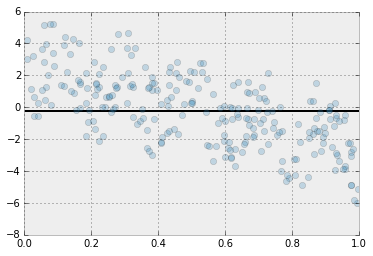

In [94]:
plot_one_feature_prediction(model_with_constraints, X_test[:, 1], y_test, "")